# Проект. Принятие решений в бизнесе.

**ОГЛАВЛЕНИЕ** 

1. [Описание анализа](#intro1)
2. [Описание данных](#intro2)
3. [Загрузка данных и подготовка их к анализу](#intro3)
4. [Часть 1. Приоритизация гипотез](#intro4)
5. [Часть 2. Анализ A/B-теста](#intro5)
6. [Выводы](#intro6)

## Описание анализа  <a id='intro1'></a>
Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовила список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты. 


## Описание данных <a id='intro2'></a>
В моем распоряжении три датасета.

- В файле hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
 - 	Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 

- Файл orders.csv. 
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.


- Файл visitors.csv. 
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Загрузка данных и подготовка их к анализу <a id='intro3'></a>

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as stats

from pandas.plotting import register_matplotlib_converters
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

#import datetime as dt
#import warnings

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),  # гипотезы
    pd.read_csv('orders.csv'),  # информацию о заказах
    pd.read_csv('visitors.csv')    # информацию о расходах на рекламу
)

In [3]:
display(hypothesis)
print()
display(orders.head(5))
print()
display(visitors.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Приведем названия столбцов к стилистически правильным:

In [4]:
# в датафрейме hypothesis
hypothesis = hypothesis.rename(
    columns = {
        'Hypothesis': 'hypothesis',
        'Reach': 'reach',
        'Impact': 'impact',
        'Confidence': 'confidence',
        'Efforts': 'efforts'
    }
)

display(hypothesis.columns) # Проверим

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [5]:
# в датафрейме orders
orders = orders.rename(
    columns = {
        'transactionId': 'transaction_id',
        'visitorId': 'visitor_id'
    }
)

display(orders.columns) # Проверим

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Посмотрим общую информацию.

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков нет.

Посмотрим есть ли в данных явные дубликаты.

In [9]:
# подсчёт явных дубликатов
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
display(visitors.duplicated().sum())

0

0

0

Явных дубликатов нет. Данные готовы к проведению анализа.

Проверим количество участников теста, совпадают ли объемы групп.

In [10]:
group_a = visitors.query('group == "A"')['visitors'].sum()
group_b = visitors.query('group == "B"')['visitors'].sum()
groups_difference = ((abs(1 - (group_a / group_b))) * 100).round(2)

print('Количество участников в группе А:', group_a)
print('Количество участников в группе В:', group_b)
print(f'Относительная разница между группами: {groups_difference} %')

Количество участников в группе А: 18736
Количество участников в группе В: 18916
Относительная разница между группами: 0.95 %


Группы практически одинаковые. Проверим не попали ли одни и те же участники в разные группы.

In [11]:
print(orders.groupby('visitor_id').agg({'group': 'nunique'}).query('group > 1').count())

group    58
dtype: int64


Мы видим, что, к сожалению, есть пользователи, которые участвовали в обеих группах теста. Это означает, что тест проведен некорректно. Возможно предварительно не был проведен тест А/А. В данной ситуации у нас нет данных с идентифокаторами пользователей в таблице visitors для того, чтобы мы могли удалить пользователей попавших в обе группы. Нет смысла удалять из одной таблицы, если они останутся во второй. Оставляем так.

**Вывод:** В данных написание столбцов приведено к стилистически правильному написанию. В данных отстутствуют пропуски и явные и неявные дубликаты. Количество участников в группах различается - разница меньше 1%. В обе группы одновременно попало 58 участников. В идеале стоило бы остановить тест, провести доработку данных и повторить тест.

Если удалить повторяющихся участников в таблице visitors, но оставить в таблице orders будет искажение данных, если оставить, то тоже будет искажение. Получается, что результаты в любом случае нельзя считать корректными, поэтому оставляем все как есть. Так как ислледование учебное - продолжим исследование.

## Часть 1. Приоритизация гипотез  <a id='intro4'></a>

Рассчитаем ICE по формуле:

ICE = влияние на пользователей(их опыт и удовлетворение от продукта)  *  уверенность в полученном влиянии на пользователя   /   стоимость тестирования гипотезы 



Рассчитаем RICE по формуле:

RICE = количество пользователей, которых затронет изменение  *  влияние на пользователей(их опыт и удовлетворение от продукта)  *  уверенность в полученном влиянии на пользователя   /   стоимость тестирования гипотезы 


### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.



In [12]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
print((hypothesis.sort_values(by='ice', ascending=False)[['hypothesis', 'ice']]).round(2))

                                          hypothesis    ice
8  Запустить акцию, дающую скидку на товар в день...  16.20
0  Добавить два новых канала привлечения трафика,...  13.33
7  Добавить форму подписки на все основные страни...  11.20
6  Показать на главной странице баннеры с актуаль...   8.00
2  Добавить блоки рекомендаций товаров на сайт ин...   7.00
1  Запустить собственную службу доставки, что сок...   2.00
5  Добавить страницу отзывов клиентов о магазине,...   1.33
3  Изменить структура категорий, что увеличит кон...   1.12
4  Изменить цвет фона главной страницы, чтобы уве...   1.00


Наиболее перспективные гипотезы:
- №8 Запустить акцию, дающую скидку на товар в день рождения, 
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. 

У них наибольший показатель ICE.

### Применим фреймворк RICE для приоритизации гипотез. Отсортируйем их по убыванию приоритета.

In [13]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
pd.options.display.max_colwidth = 100
print(hypothesis.sort_values(by='rice', ascending=False)[['hypothesis', 'rice']])

                                                                                            hypothesis  \
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
8                                              Запустить акцию, дающую скидку на товар в день рождения   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
4                     Изменить цвет фона главн

И снова наиболее перспектичнвные гипотезы:
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,
- и №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
- но к ним вместо 8-ой присоединилась 2-ая (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...) и 6-я (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...) гипотезы. 

И на первом месте сейчас стоит 7-ая (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), т.к. у нее показатель RICE выше всех - 112. 

### Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. 

In [14]:
print(hypothesis.sort_values(by='reach', ascending=False)[['ice', 'rice', 'reach']])

         ice   rice  reach
7  11.200000  112.0     10
2   7.000000   56.0      8
3   1.125000    9.0      8
6   8.000000   40.0      5
0  13.333333   40.0      3
4   1.000000    3.0      3
5   1.333333    4.0      3
1   2.000000    4.0      2
8  16.200000   16.2      1


У гипотез изменились места, т.к. при рассчете RICE учитывается не только влияние, уверенность, усилия/простота расчета приоритезации гипотез, но и охват аудитории (т.е. как много пользователей затронет та или иная гипотеза), что не учитывается при расчете ICE.

## Часть 2. Анализ A/B-теста <a id='intro5'></a>

### Построим график кумулятивной выручки по группам. 

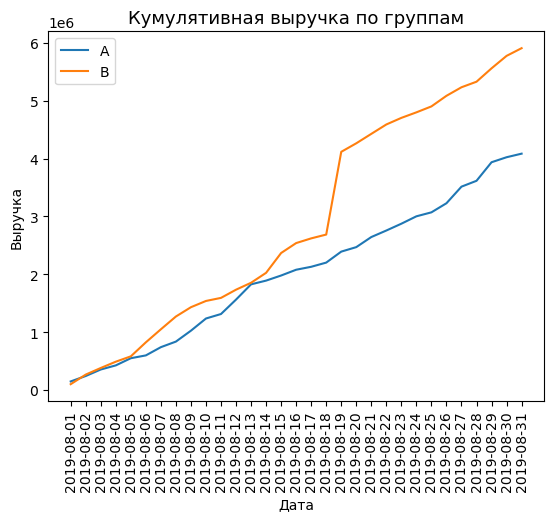

In [15]:
dates_groups = orders[['date', 'group']].drop_duplicates()  #Создадим массив уникальных пар значений дат и групп теста 

orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(    #Агрегируем значения
        {
            'date': 'max',   
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.xticks(rotation = 90)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по группам', fontsize=13)
plt.legend()
plt.show;

Примерно в середине теста сегмент B вырвался вперёд и продолжал лидировать до конца теста. Похоже, что аномально большие заказы всё-таки влияют на результаты. При заключительном анализе их нужно удалить.

### Построим график кумулятивного среднего чека по группам.

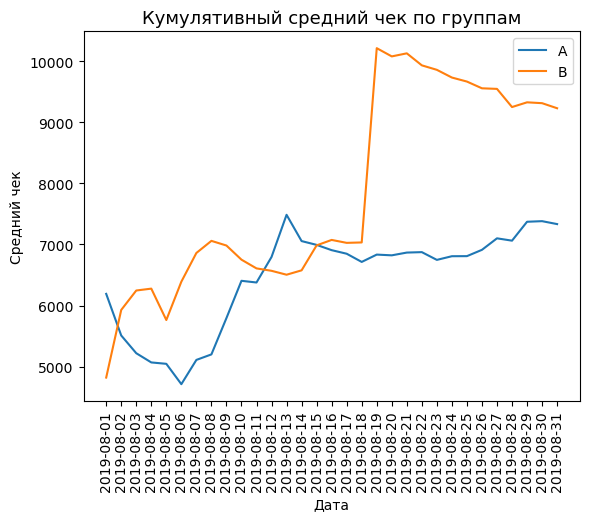

In [16]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.xticks(rotation = 90)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по группам', fontsize=13)
plt.legend()
plt.show;

Кумулятивное значение среднего чека по сегментам продолжает колебаться. Прежде, чем принимать решение по этой метрике надо провести дополнительный анализ выбросов, которые искажают результаты.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

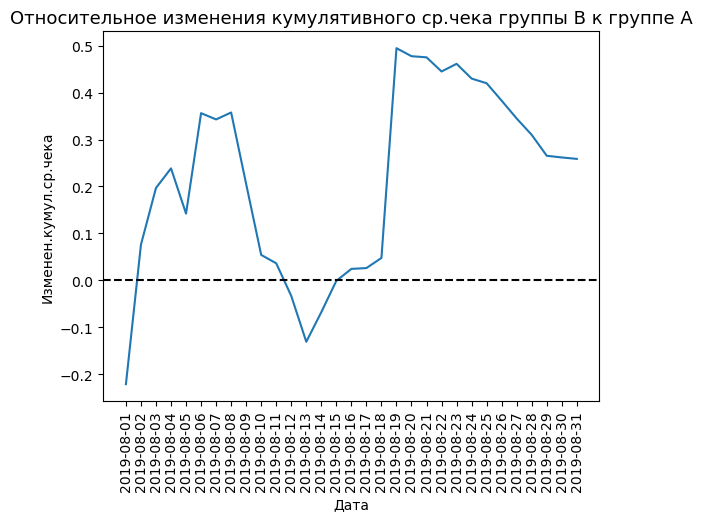

In [17]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation = 90)
plt.xlabel('Дата')
plt.ylabel('Изменен.кумул.ср.чека')
plt.title('Относительное изменения кумулятивного ср.чека группы В к группе А', fontsize=13)
plt.show;

Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы.

### Построим график кумулятивного среднего количества заказов на посетителя по группам. 

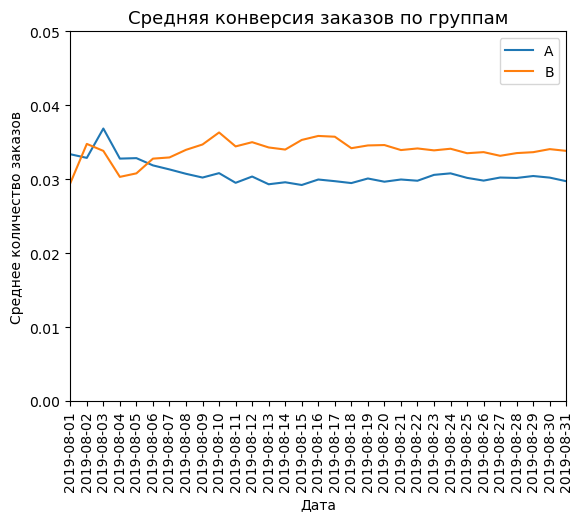

In [18]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.axis(['2019-08-01', '2019-08-31',  0, 0.05])
plt.xticks(rotation = 90)
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.title('Средняя конверсия заказов по группам', fontsize=13)
plt.show
plt.legend();

В начале теста сегмент A имел бОльшую конверсию, но постепенно сегмент B выровнялся и зафиксировался примерно около одного значения, больше значения сегмента A.
Мы изменили масштаб графика, чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое: от 3% до 4%. Если не задать масштаб осей, будет казаться, что колебания продолжаются, и конверсия не установилась около своего среднего значения.

У группы В показатель конверсии выше.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

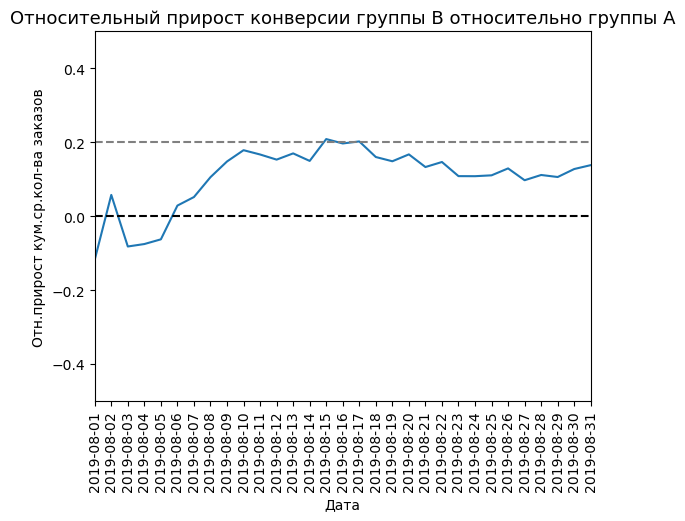

In [19]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.axis(['2019-08-01', '2019-08-31', -0.5, 0.5])
plt.xticks(rotation = 90)
plt.xlabel('Дата')
plt.ylabel('Отн.прирост кум.ср.кол-ва заказов')
plt.title('Относительный прирост конверсии группы B относительно группы A', fontsize=13)
plt.show;

Почти с самого начала теста группа B лидирует по конверсии: становится лучше и лучше, максимальное значение фиксировалось около прироста в 20% относительно группы A.

### Построим точечный график количества заказов по пользователям.

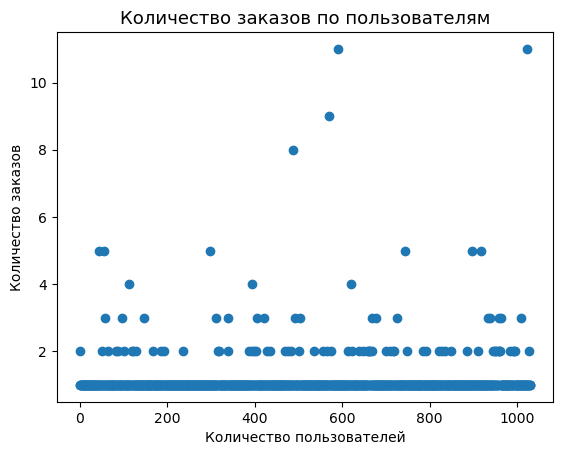

In [20]:
orders_by_users = (
   orders.groupby('visitor_id', as_index=False)
   .agg({'transaction_id': 'nunique'})
)

# серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['transaction_id']) 

plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по пользователям', fontsize=13)
plt.show;

Большенство пользователей сделали 1 заказ. Но видно, что есть те, кто сделал 2-3 и более заказов. Надо посмотреть их долю в общем количестве, посчитав выборочные перцентили.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [21]:
print(np.percentile(orders_by_users['transaction_id'], [95, 99])) 

[2. 4.]


Теперь мы видим, что не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей — больше четырех заказов. Таким образом отметку в 99-й перцентиль можно считать анаомалиями и исключить эти данные при дальнейшем анализе "чистых данных".


### Построим точечный график стоимостей заказов.

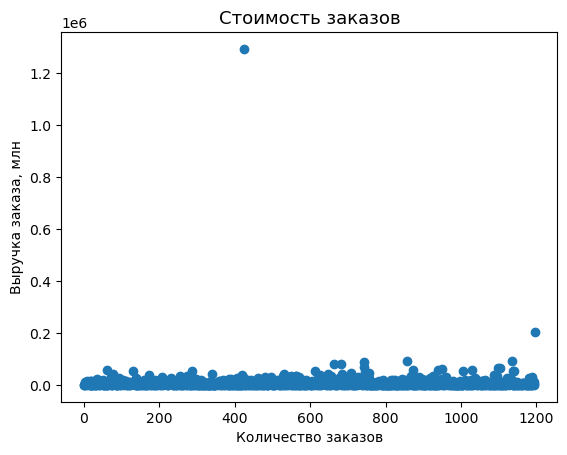

In [22]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])

plt.xlabel('Количество заказов')
plt.ylabel('Выручка заказа, млн')
plt.title('Стоимость заказов', fontsize=13)
plt.show;

На графике видно, что большинство заказов на стоимость до 170 тыс. Но есть выброс в районе 1,3 млн. По графику можно было бы выбрать границу аномальных заказов от 210 000. Однако допускается отсеивать не более 5% наблюдений с крайними значениями. Проверим долю стоимостей в общем количестве, посчитав выборочные перцентили.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [23]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более, чем у 5% заказов чек дороже 28000 рублей. И не больше, чем у 1% заказов — дороже 58233 рублей. Таким образом отметку в 99-й перцентиль можно считать тоже анаомальной стоимостью заказов и исключить эти данные при дальнейшем анализе "чистых данных".

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Мы посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 
- Нулевая: *различий в среднем количестве заказов между группами нет*. 
- Альтернативная: *различия в среднем между группами есть*.

Т.к. критерии у нас измерены количественно, выборки независимые, пользователи в различных группах, а так же имеются значительные выбросы то лучше использовать критерий Манна-Уитни, чтобы выбивающееся значение существенно не влияло на результат.

In [24]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

# зак для кажд польз-ля группы А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor', 'orders']

# зак для кажд польз-ля группы В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor', 'orders'] 

# кол-во заказов в группе А (список с кол-м заказов для кажд.польз; 0-для тех, кто не зак; 
# разнице между суммой посетителей и количеством записей )
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

# кол-во заказов в группе B (список с кол-м заказов для кажд.польз; 0-для тех, кто не зак; 
# разнице между суммой посетителей и количеством записей )
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))   # применим МУ и отформатируем p-value
print('Относительный прирост среднего группы B к конверсии группы A:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))   # прирост ср гр В к гр А

p-value: 0.01679
Относительный прирост среднего группы B к конверсии группы A: 0.138


P-value 0.01679 меньше 0.05, значит нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13,8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы.

- Нулевая: различий в среднем чеке между группами нет.
- Альтернативная: различия в среднем между группами есть.

Критерии у нас так же измерены количественно, выборки независимые, пользователи в различных группах, и так же имеются значительные выбросы то использовать будем так же критерий Манна-Уитни, чтобы выбивающееся значение существенно не влияло на результат.

In [25]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Относительное различие среднего чека между сегментами: 0.259


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между сегментами почти 26%

Приступим к анализу аномалий.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примим за аномальных пользователей тех, кто совершил 4 заказа и более (99-й перцентил), за аномальную стоимость заказа - сумму свыше 58233 рублей (так же 99-й перцентил). Так мы уберём 1% пользователей с наибольшим числом заказов и около 1% заказов с наибольшей стоимостью.

In [26]:
# Подготовка к очистке от аномалий данных
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] >= np.percentile(orders_by_users['transaction_id'], 99)]['visitor'],
        orders_by_users_b[orders_by_users_b['orders'] >= np.percentile(orders_by_users['transaction_id'], 99)]['visitor'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']

abnormal_users = (      # вычисляем аномальные данные
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [27]:
# Посмотрим относительные потери пользователей после удаления аномальных
abnormal_users.value_counts().count()/len(orders['visitor_id'].unique()) * 100

1.939864209505335

Потери пользователей составили 1,9%

Посчитаем статистическую значимость различия среднего количества заказов после удаления аномальных пользователей.

Сформулируем гипотезы.

- Нулевая: различий в среднем количестве заказов на посетителя по «очищенным» данным между группами нет.
- Альтернативная: различия в среднем между группами есть.

Критерии у нас те же - использовать будем критерий Манна-Уитни.

In [28]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', '{0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост среднего группы B к конверсии группы A:', '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value: 0.01390
Относительный прирост среднего группы B к конверсии группы A: 0.151


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент B значительно лучше сегмента A. P-value меньше 0.05, В среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен примерно 15%.

In [29]:
#относительные потери пользователей
abnormal_users.value_counts().count()/len(orders['visitor_id'].unique())*100

1.939864209505335

Мы потеряли примерно 2% данных. Это вполне допустимо.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем гипотезы.

- Нулевая: различий в среднем чеке заказа по «очищенным» данным между группами нет.
- Альтернативная: различия в среднем между группами есть.

Критерии у нас те же - использовать будем критерий Манна-Уитни.

In [30]:
print('p-value:', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие среднего чека между сегментами:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.959
Относительное различие среднего чека между сегментами: -0.014


Статистической значимости между группами нет. Это значит, что после удаления выбросов в данных меньше шума; дисперсия снизилась.  Нулевая гипотеза не отвергается.

### Примим решение по результатам теста и объясним его. 

На основании проведенного анализа, правильным решение будет остановить тест. 

Статистически значимого различия ни до, ни после удаления аномалий в группах нет. Снижение ср.чека в группе В по "очищенным" данным получено случайным образом. 

По конверсии победила группа В. Увеличение конверсии (решения стать покупателем) - перспектива для роста выручки.

## Выводы <a id='intro6'></a>

**1.** На стадии предоработки данных были выявлены значительные нарушения проведения теста, а именно - различное количество участников в группах и совпадающие участники в обеих группах. Так как это серьёзное нарушение и в реальной работе нужно было бы вообще отклонить результаты А/В теста, проведенного по таким данным. Из-за дубляжа пользователей в группе А и В, тест следовало признать некорректным и остановить сразу. Вернуться к стадии проведения теста А/А, отфильтровать данные и начать заново. Но мы пригнорируем данную находку. 

Далее я приоритезировала гипотезы ICE и RICE способами. Лидируют гипотезы примерно одни и те же:
- №7 Добавить форму подписки на все основные страни.. - с самым большим охватом аудитории
- №0 Добавить два новых канала привлечения трафика...

Т.к. нужно учитывать не только влияние, уверенность, усилия/простота расчета приоритезации гипотез, но и охват аудитории я не ставлю в приоритет гипотезу №8 Запустить акцию, дающую скидку на товар в день... Несмотря на высокий показатель ICE у нее самый маленький показатель охвата аудитории.

**2.** Оценила результаты A/B-теста визуально и выяснила, что в данных есть выбросы и нашла границу для их определения. Для количества заказов на пользователя она составили 4 и более заказов; для стоимости заказов - 58233 и более.

Посчитала статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по "сырым" данным — без удаления аномальных пользователей и по "очищенным" данным. Использовала непараметрический тест Уилкоксона-Манна-Уитни, с помощью которого проранжировала две выборки по порядку от меньшего к большему и сравнила ранги одних и тех же значений, попавших в обе выборки. Т.к. вероятности получения разных значений критерия Манна-Уитни рассчитаны теоретически, то этот метод дает возможность делать вывод о различии или его отсутствии для любого заданного уровня значимости.

Результаты помогли определить, что тест можно считать состоявшимся, т.е. принимаем решение остановить его. По результатам победила группа В - при отсутствии статистически значимого различия по среднему чеку (как по "сырым", так и по "очищенным" данным) в этой группе наблюдается увеличение конверсии по сравниния с группой А. А соответственно и рост выручки.